In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from numba import jit

%matplotlib inline

In [2]:
from conditional_bg.models.double_well import double_well_model
from conditional_bg.models.gaussian import gaussian_model
from conditional_bg.likelihood.gaussian_likelihood import gaussian_likelihood

from conditional_bg.network.coupling_networks import MLP
from conditional_bg.network.conditional_generator import conditional_generator
from conditional_bg.network.dataset import transform_dataset
from conditional_bg.training.train_schedule import schedule_trainer
from conditional_bg.samplers.inertial_langevin import inertial_langevin_integrator


In [3]:
def cv(x):
    # y + x
    return (x[:, 1] + x[:, 0]).unsqueeze(-1)

def cv_np(x):
    # y + x
    return (x[:,1] + x[:,0])

In [4]:
device = torch.device("cuda:0")

system = double_well_model(device=device, B=10)

prior = gaussian_model(system.n_particles, system.dimensions, reference_T=1 , device=device)

T_ref = 1
k = 25
CV_range = [-3, 3]
likelihood = gaussian_likelihood(k, 0)

In [5]:
# Load and shuffle train data

train_conf = []
train_cond = []
train_T = []

for ref_c in np.linspace(CV_range[0], CV_range[1], 5):

    c = system.sample(n_samples=1500, n_cycles=1000, T=1, cv=cv_np, likelihood=likelihood, ref_center=ref_c, shuffle=True)
    train_conf.append(c)
    train_cond.append(c.new_ones(c.shape[0], 1) * ref_c)
    train_T.append(c.new_ones(c.shape[0], 1) * T_ref)
    
train_conf = torch.vstack(train_conf)
train_cond = torch.vstack(train_cond)
train_T = torch.vstack(train_T)


In [6]:
n_blocks = 3

masks = torch.from_numpy(np.array([[1, 0], [0, 1]]).astype(np.float32)).to(device)

network_parameters = {   "n_layers" : 3,
                            "n_hidden" : 64,
                            "activation" : torch.nn.Tanh}

coupling_layer_params = {"A" : {"masks" : masks,
                            "transform_network" :  MLP,
                            "transform_network_parameters" : network_parameters}}


generator = conditional_generator(
                                    system.dofs, prior, system, "A"*n_blocks, 
                                    device, coupling_layer_params, condition_function=cv, condition_dim=1, likelihood=likelihood, norm_range_condition=CV_range
                                    ).to(device)

train_dataset = transform_dataset(generator=generator, 
                                    data_tensor=train_conf, 
                                    data_temperature=train_T, 
                                    test_zx_temperature=[0.5, 2], 
                                    condition_tensor=train_cond, 
                                    CV_range=CV_range, 
                                    test_fraction=2000/len(train_conf),
                                    shuffle_data=True)


train_routine = schedule_trainer(generator, train_conf, 
                                    train_cond, latent_configurations=prior.sample(50000))


In [7]:
# Training!

loss_history = train_routine.train_schedule("conditioned_protocol.yaml", train_dataset)


 Epochs:	100 
 LR:		1.00e-02  
 Batch Size:	128  
 N_Conditions:	1 
 T:		0.5 - 5 
 w_xz/w_zx:	1/0

E:   1/100  |  Train:   xz -1.269  |  Val.:   xz -2.523  zx  9.098e+00  F_xz 0.95  F_zx 0.59  E_xz  5.58e-01  E_zx  5.56e+00
E:   2/100  |  Train:   xz -2.724  |  Val.:   xz -2.769  zx  8.594e+00  F_xz 0.98  F_zx 0.66  E_xz  7.21e-01  E_zx  4.36e+00
E:   3/100  |  Train:   xz -2.891  |  Val.:   xz -2.981  zx  8.258e+00  F_xz 0.97  F_zx 0.72  E_xz  9.03e-01  E_zx  3.39e+00
E:   4/100  |  Train:   xz -2.946  |  Val.:   xz -2.960  zx  8.338e+00  F_xz 0.99  F_zx 0.70  E_xz  6.44e-01  E_zx  4.02e+00
E:   5/100  |  Train:   xz -2.944  |  Val.:   xz -2.949  zx  8.390e+00  F_xz 0.98  F_zx 0.69  E_xz  5.85e-01  E_zx  4.18e+00
E:   6/100  |  Train:   xz -2.944  |  Val.:   xz -3.014  zx  8.295e+00  F_xz 0.98  F_zx 0.70  E_xz  6.12e-01  E_zx  3.89e+00
E:   7/100  |  Train:   xz -2.907  |  Val.:   xz -3.051  zx  8.277e+00  F_xz 0.98  F_zx 0.71  E_xz  5.83e-01  E_zx  3.89e+00
E:   8/100  |  Train:   x

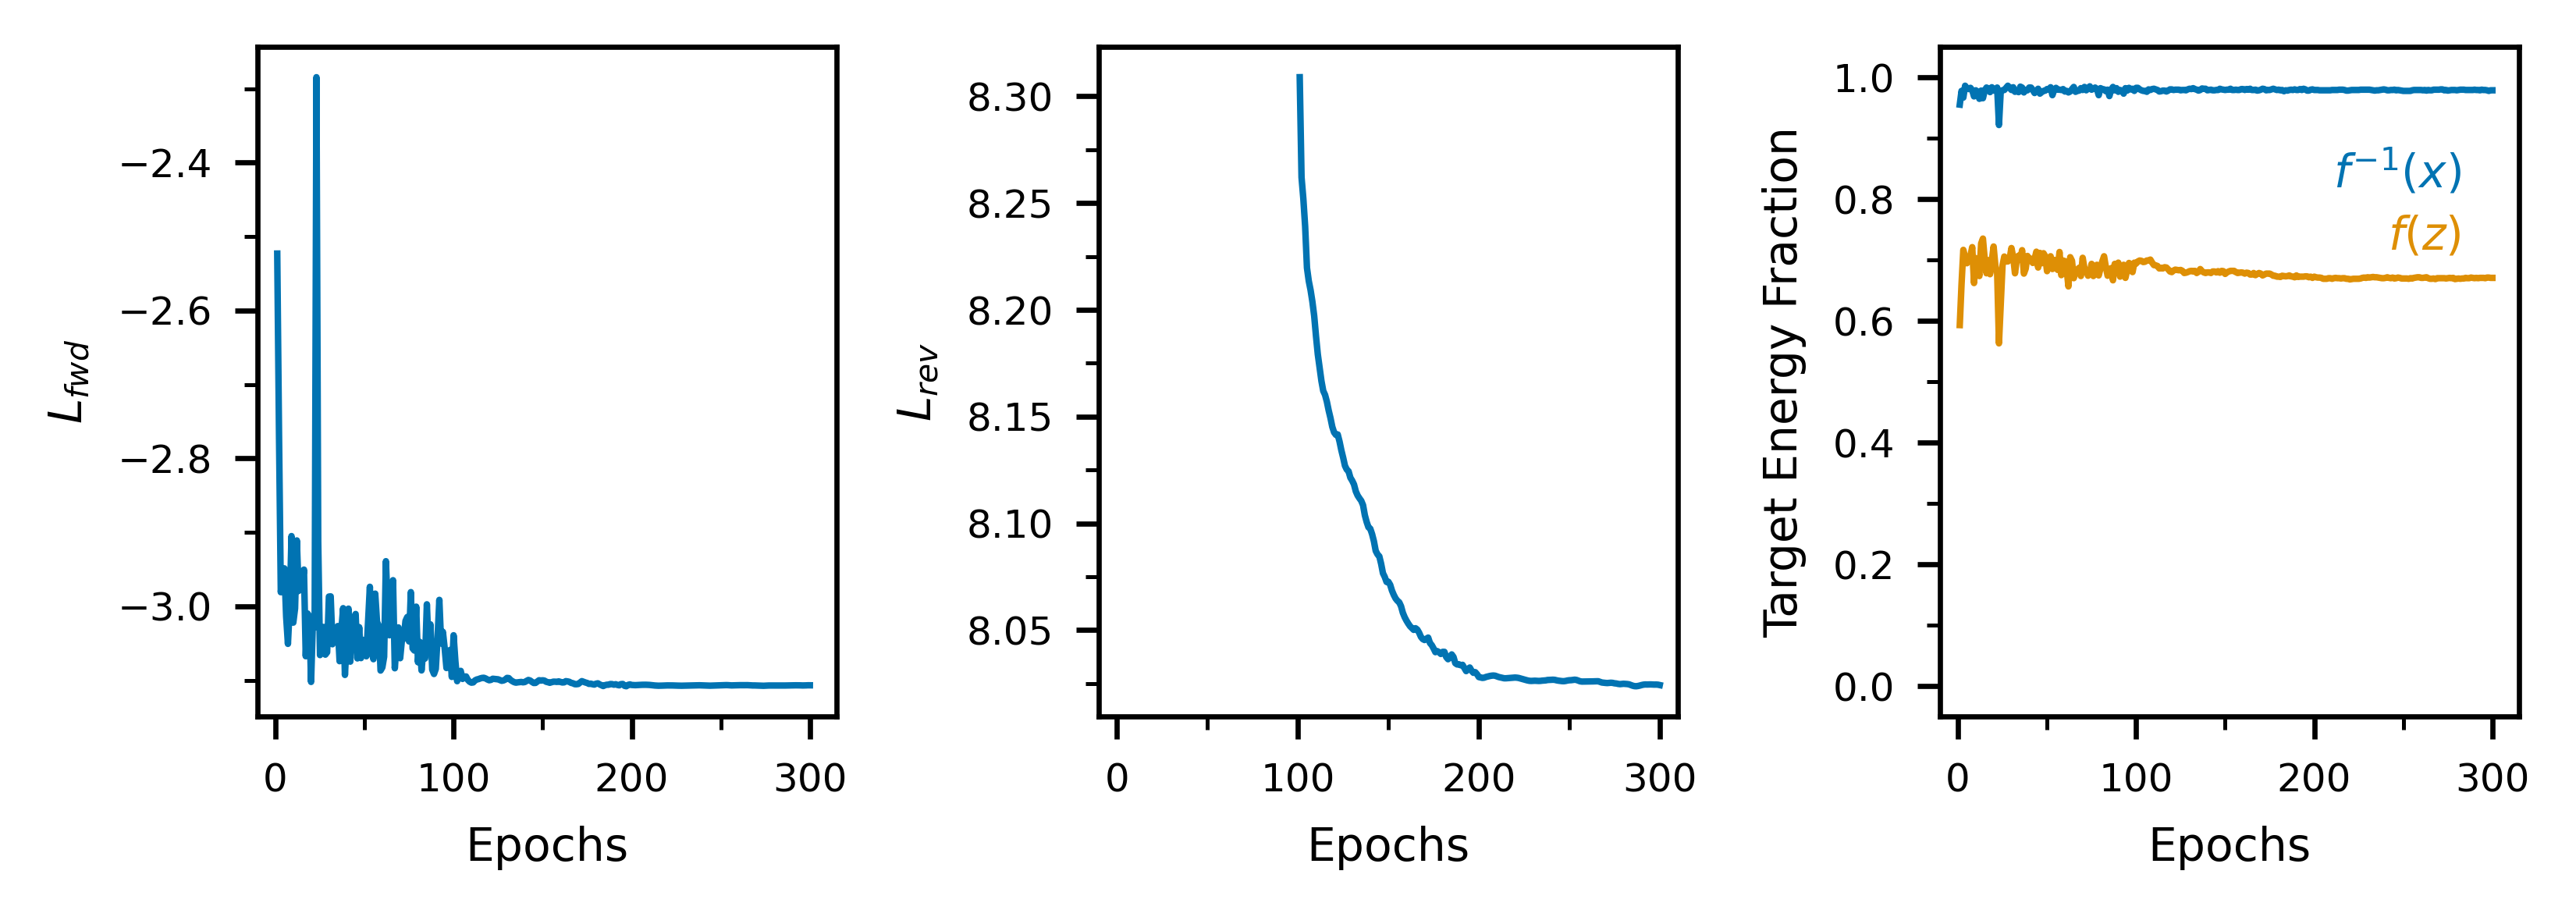

In [8]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")
mpl.rcParams.update({'font.size': 7})

fig_size = (14 * 0.393701, 5 * 0.393701)

fig, ax = plt.subplots(1, 3, figsize = fig_size, dpi = 600, sharex=False)

epochs = [loss_history[i][0] for i in range(len(loss_history))]
losses = np.array([loss_history[i][1] for i in range(len(loss_history))])

losses[:100, 1] = np.nan

ax[0].plot(epochs, losses[:, 0], lw = 1)
ax[1].plot(epochs, losses[:, 1], lw = 1)
ax[2].plot(epochs, losses[:, 8], lw = 1)
ax[2].plot(epochs, losses[:, 9], lw = 1)

[ax[i].tick_params(axis='both', which='major', labelsize=6) for i in range(3)] 

ax[2].text(0.9, 0.85, '$f^{-1}(x)$',
        verticalalignment='top', horizontalalignment='right',
        transform=ax[ 2].transAxes, fontsize=7, color="C0")

ax[2].text(0.9, 0.75, '$f(z)$',
        verticalalignment='top', horizontalalignment='right',
        transform=ax[ 2].transAxes, fontsize=7, color="C1") 

ax[2].set_ylim(-0.05, 1.05)
[ax[i].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))for i in range(3)]
[ax[i].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2)) for i in range(3)]

ax[0].set_xlim(-10, None)
ax[1].set_xlim(-10, None)
ax[2].set_xlim(-10, None)

[ax[i].set_xlabel("Epochs") for i in range(3)]
ax[0].set_ylabel("$L_{fwd}$") 
ax[1].set_ylabel("$L_{rev}$") 
ax[2].set_ylabel("Target Energy Fraction")

plt.tight_layout()

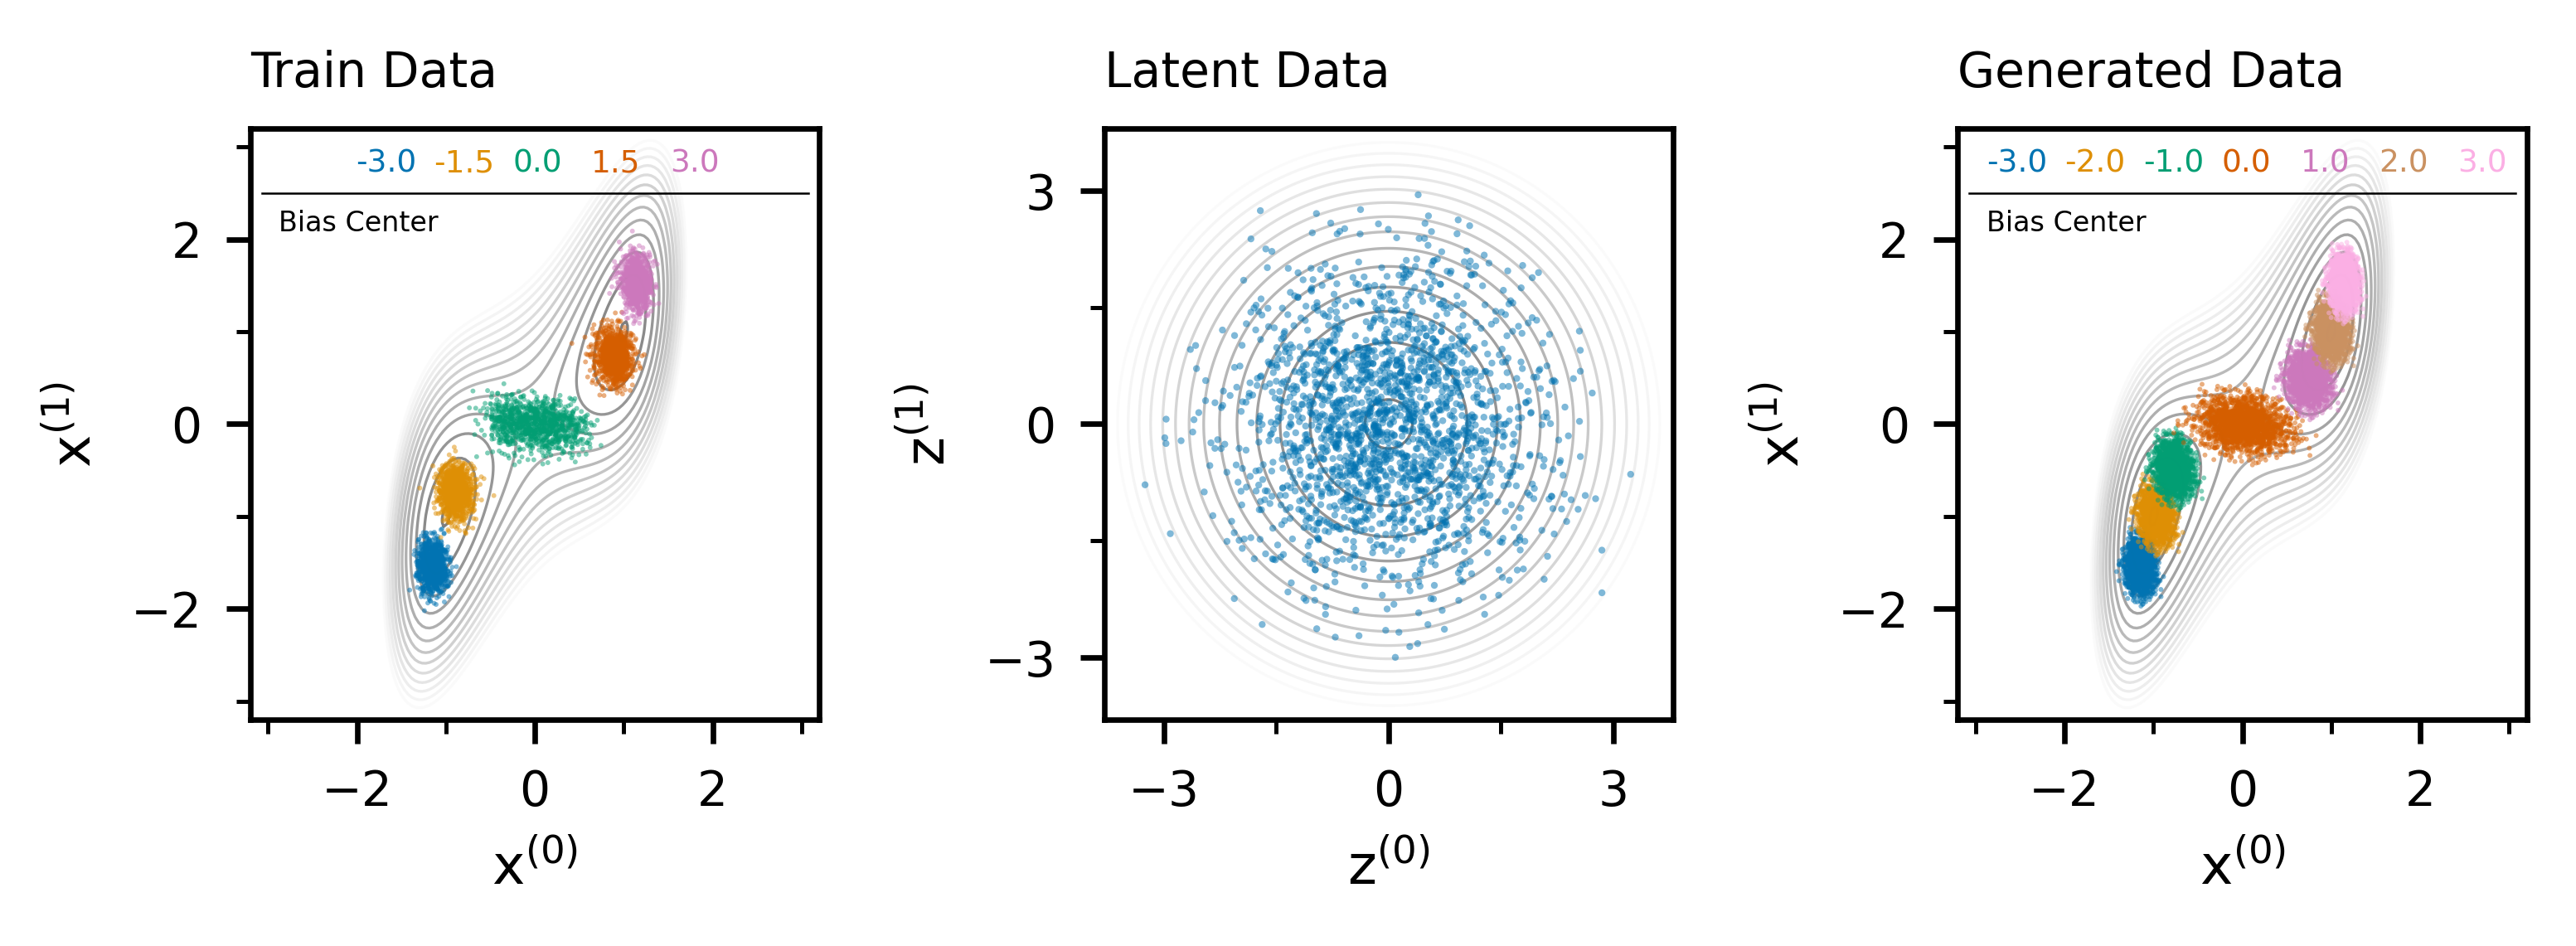

In [9]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")
mpl.rcParams.update({'font.size': 8})

fig_size = (15 * 0.393701, 4 * 0.393701)

fig, ax = plt.subplots(1,3, figsize = fig_size, dpi = 600, sharex=False, sharey=False)


#
# Train Data
#


legend_y = 0.94

for i, ref_c in enumerate(torch.unique(train_dataset.train_c_xz)):
    
    x = train_dataset.train_data_xz[torch.where(train_dataset.train_c_xz == ref_c)[0]].cpu().numpy()

    ax[0].scatter(x[:,0], x[:, 1], s=0.5, alpha=0.5, edgecolors="None")

    ax[0].text(0.185 + 0.138 * i, legend_y,"{:.1f}".format(ref_c),
               horizontalalignment='left',
               verticalalignment='center',
               fontsize= 4.5,
               color="C{}".format(i),
               transform = ax[0].transAxes)


ax[0].text(0.05, legend_y-0.1,"Bias Center",
           horizontalalignment='left',
           verticalalignment='center',
           fontsize= 4,
           transform = ax[0].transAxes)

ax[0].plot([0.02,1-0.02], [legend_y - 0.05, legend_y - 0.05], transform = ax[0].transAxes, lw=0.3, c="0")


x = np.linspace(-4,4, 200)
y = np.linspace(-4,4, 200)

X, Y = np.meshgrid(x, y)

Z = np.zeros([len(X),len(Y)])

for i in range(len(X)):
    for j in range(len(Y)):

        Z[i,j] = generator.posterior.potential_energy(np.array([X[i][j], Y[i][j]])) 
        
ax[0].contour(X,Y,Z, levels=np.arange(0.1,40, 3), cmap = "Greys_r", alpha = .5, linewidths=0.4, zorder = 0)

ax[0].set_title("Train Data", fontsize= 7, loc="left")

ax[0].set_ylim(-3.2,3.2)
ax[0].set_xlim(-3.2,3.2)
ax[0].set_yticks(np.linspace(-2, 2, 3))
ax[0].set_xticks(np.linspace(-2, 2, 3))


#
# Generated Data
#

N = 2000

ref_z = generator.prior.sample(N)

z = ref_z.cpu().numpy()
ax[1].scatter(z[:,0], z[:, 1], s=1, alpha=0.5, edgecolors="None", zorder=10)


for i, ref_c in enumerate(np.linspace(-3, 3, 7)):
    
    with torch.no_grad():

        z, sample_coord, log_w = generator.sample(N, 1, ref_condition= torch.ones(N, 1).cuda() * ref_c, reference_latent=ref_z)

    x = sample_coord.cpu().numpy()

    ax[2].scatter(x[:,0], x[:, 1], s=0.5, alpha=0.5, edgecolors="None")

    ax[2].text(0.05 + 0.138 * i, legend_y,"{:.1f}".format(ref_c),
               horizontalalignment='left',
               verticalalignment='center',
               fontsize= 4.5,
               color="C{}".format(i),
               transform = ax[2].transAxes)


ax[2].text(0.05, legend_y-0.1,"Bias Center",
           horizontalalignment='left',
           verticalalignment='center',
           fontsize= 4,
           transform = ax[2].transAxes)

ax[2].set_title("Generated Data", fontsize= 7, loc="left")

ax[2].plot([0.02,1-0.02], [legend_y - 0.05, legend_y - 0.05], transform = ax[2].transAxes, lw=0.3, c="0")


x = np.linspace(-4,4, 200)
y = np.linspace(-4,4, 200)

X, Y = np.meshgrid(x, y)

Z = np.zeros([len(X),len(Y)])

for i in range(len(X)):
    for j in range(len(Y)):

        Z[i,j] = generator.posterior.potential_energy(np.array([X[i][j], Y[i][j]]))

ax[2].contour(X,Y,Z, levels=np.arange(0.1,40, 3), cmap = "Greys_r", alpha = .5, linewidths=0.4, zorder = 0)


Z = np.zeros([len(X),len(Y)])

for i in range(len(X)):
    for j in range(len(Y)):

        Z[i,j] = X[i][j]**2 + Y[i][j]**2

ax[1].contour(X,Y,Z, levels=np.arange(0.1,15,1), cmap = "Greys_r", alpha = .5, linewidths=0.4, zorder = 0)


ax[1].set_title("Latent Data", fontsize= 7, loc="left")

[ax[i].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2)) for i in range(3)]
[ax[i].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2)) for i in range(3)]

[ax[i].tick_params(axis='both', which='major', labelsize=7) for i in range(3)]
[ax[i].tick_params(axis='both', which='minor', labelsize=7) for i in range(3)]

ax[1].set_ylim(-3.8,3.8)
ax[1].set_xlim(-3.8,3.8)
ax[1].set_yticks(np.linspace(-3, 3, 3))
ax[1].set_xticks(np.linspace(-3, 3, 3))

ax[2].set_ylim(-3.2,3.2)
ax[2].set_xlim(-3.2,3.2)
ax[2].set_yticks(np.linspace(-2, 2, 3))
ax[2].set_xticks(np.linspace(-2, 2, 3))

ax[0].set_xlabel("x$^{(0)}$")
ax[0].set_ylabel("x$^{(1)}$")

ax[1].set_xlabel("z$^{(0)}$")
ax[1].set_ylabel("z$^{(1)}$")

ax[2].set_xlabel("x$^{(0)}$")
ax[2].set_ylabel("x$^{(1)}$")


plt.subplots_adjust(wspace=.5)

## TPS

### Sampling

In [10]:

N_paths = 5000
path_model = inertial_langevin_integrator(system, length=250000,dt=1e-2, gamma=20, m=1, T=1)

In [11]:
@jit(nopython=True)
def check_state(x):
    
    a = (x[0]+1)**2 + (x[1]+1)**2
    b = (x[0]-1)**2 + (x[1]-1)**2
    
    if a < 0.1:
        return -1
    elif b < 0.1:
        return 1
    else:
        return 10

In [12]:

def sample_path(shooting_points, sp_index, path_model, check_state, path_stride):
    
    shooting_point = shooting_points[sp_index]

    v = np.random.normal(loc=0, scale=np.sqrt(path_model.T), size=system.dofs)

    path_fw, _ = path_model.generate_flexible_path(shooting_point, v, check_state, 100000, path_stride)
    path_rv, _ = path_model.generate_flexible_path(shooting_point, -v, check_state, 100000, path_stride)
    
    trial_path = np.vstack([path_rv[::-1], path_fw[1:]])
        
    return trial_path

In [13]:
*_, shooting_points, _ = generator.sample(N_paths, T=T_ref, ref_condition=torch.zeros(N_paths, 1).to(device), resample=True)
shooting_points = shooting_points.cpu().numpy()

In [14]:

transition_paths = []

for i in range(N_paths):
    transition_paths.append(sample_path(shooting_points, i, path_model, check_state, 1))

### Visualization

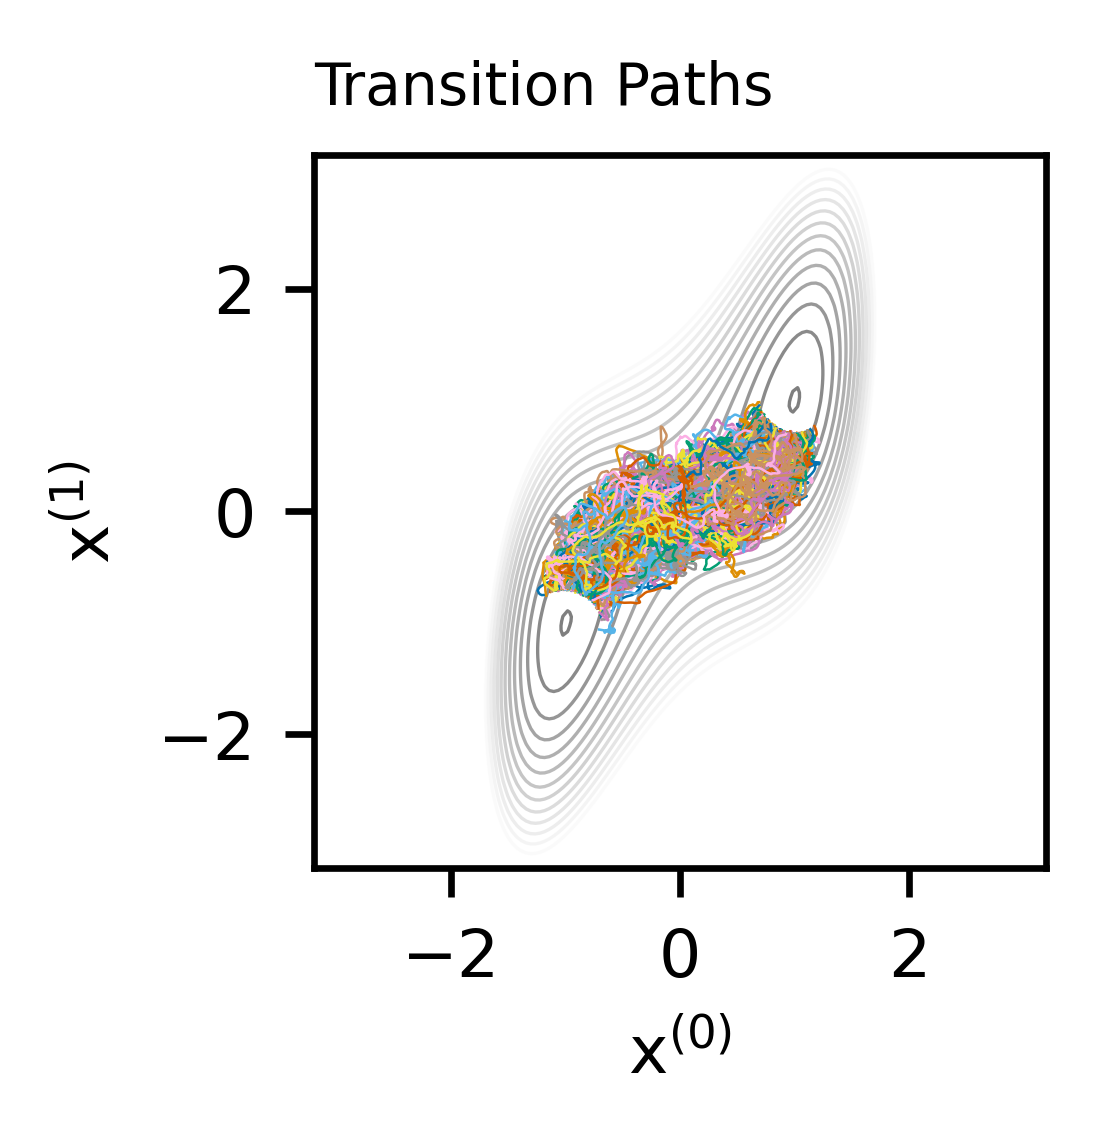

In [15]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")
mpl.rcParams.update({'font.size': 8})

fig_size = (4 * 0.393701, 4 * 0.393701)

fig, ax = plt.subplots(1, figsize = fig_size, dpi = 600, sharex=False, sharey=False)


for TP in transition_paths[::10]:
    ax.plot(TP[:,0], TP[:,1], lw=0.3)


x = np.linspace(-4,4, 200)
y = np.linspace(-4,4, 200)

X, Y = np.meshgrid(x, y)

Z = np.zeros([len(X),len(Y)])

for i in range(len(X)):
    for j in range(len(Y)):

        Z[i,j] = generator.posterior.potential_energy(np.array([X[i][j], Y[i][j]])) 
        
ax.contour(X,Y,Z, levels=np.arange(0.1,40, 3), cmap = "Greys_r", alpha = .5, linewidths=0.4, zorder = 0)

ax.set_title("Transition Paths", fontsize= 7, loc="left")

ax.set_ylim(-3.2,3.2)
ax.set_xlim(-3.2,3.2)
ax.set_yticks(np.linspace(-2, 2, 3))
ax.set_xticks(np.linspace(-2, 2, 3))


ax.set_xlabel("x$^{(0)}$")
ax.set_ylabel("x$^{(1)}$")

plt.subplots_adjust(wspace=.5)

### Reweighting

In [16]:
log_path_weights = []
    
for trial_path in transition_paths:
    
    forward_state = check_state(trial_path[-1])
    reverse_state = check_state(trial_path[0])

    if forward_state + reverse_state != 0:
        log_w = -np.inf
        
    else:
        
        torch_trial_path = torch.from_numpy(trial_path.copy()).to(generator.device)
        
        log_w = generator.log_path_weight(torch_trial_path, 0.0, T_ref, generated_distribution=False).item()

    log_path_weights.append(log_w)

In [17]:
weights = np.exp(log_path_weights - np.max(log_path_weights))


Text(0, 0.5, '$p(\\tau$)')

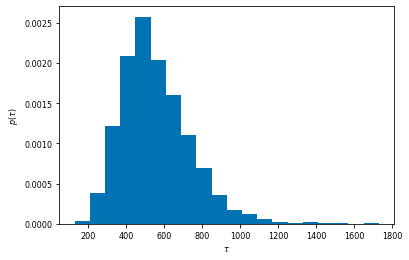

In [18]:
path_lengths_unweighted = [len(TP) for TP in transition_paths]

plt.hist(path_lengths_unweighted, weights=weights, bins=20, density=True)
plt.xlabel("$\\tau$")
plt.ylabel("$p(\\tau$)")